In [1]:
import numpy as np
import geopandas as gpd
import pickle
import googlemaps
import pandas as pd
import psycopg2

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
# import matplotlib
# from mpl_toolkits.axes_grid1 import make_axes_locatable

import SetCover
import DBScaner
import Definition
import Itinerary

def save_fig(name):
    fig.savefig(name,dpi=80,bbox_inches='tight', pad_inches=0.02, format = 'png')

%matplotlib inline

### The ebird Data

The bird data has been trasnform to a Postgres SQL database.  This section of the code reads form this database to do the calculations. 

In [7]:
dfAll = pd.read_csv('../../../ebd_US-WI_201801_201912_relApr-2020/ebd_US-WI_201801_201912_relApr-2020.txt'
                ,delimiter="\t")

/Users/casanova/miniconda3/envs/insight/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (43) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [9]:
dfAll.head(5)

,GLOBAL UNIQUE IDENTIFIER,LAST EDITED DATE,TAXONOMIC ORDER,CATEGORY,COMMON NAME,SCIENTIFIC NAME,SUBSPECIES COMMON NAME,SUBSPECIES SCIENTIFIC NAME,OBSERVATION COUNT,BREEDING BIRD ATLAS CODE,...,NUMBER OBSERVERS,ALL SPECIES REPORTED,GROUP IDENTIFIER,HAS MEDIA,APPROVED,REVIEWED,REASON,TRIP COMMENTS,SPECIES COMMENTS,Unnamed: 46
0,URN:CornellLabOfOrnithology:EBIRD:OBS562728250,2019-03-17 19:01:35,31254,species,Common Redpoll,Acanthis flammea,NaN,NaN,25,NaN,...,2.0,1,G2858841,0,1,1,NaN,NaN,NaN,NaN
1,URN:CornellLabOfOrnithology:EBIRD:OBS588703980,2019-03-17 19:25:37,31254,species,Common Redpoll,Acanthis flammea,NaN,NaN,10,NaN,...,1.0,1,NaN,0,1,1,NaN,NaN,NaN,NaN
2,URN:CornellLabOfOrnithology:EBIRD:OBS586958003,2018-03-12 23:42:55,8012,issf,Red-tailed Hawk,Buteo jamaicensis,Red-tailed Hawk (calurus/alascensis),Buteo jamaicensis calurus/alascensis,1,NaN,...,2.0,0,NaN,1,1,1,NaN,NaN,"Very dark when perched, similar to a dark-morp...",NaN
3,URN:CornellLabOfOrnithology:EBIRD:OBS628979112,2018-08-07 03:24:03,18416,species,Red-eyed Vireo,Vireo olivaceus,NaN,NaN,6,P,...,21.0,1,G3267530,0,1,0,NaN,"65F, sky&#61;1, 1 staff, 19 adult volunteers",NaN,NaN
4,URN:CornellLabOfOrnithology:EBIRD:OBS646834396,2018-08-16 14:45:12,31361,species,Pine Siskin,Spinus pinus,NaN,NaN,1,NaN,...,1.0,1,NaN,0,1,1,NaN,NaN,Smaller and more striped than a house finch. S...,NaN


In [10]:
dfAll.columns

Index(['GLOBAL UNIQUE IDENTIFIER', 'LAST EDITED DATE', 'TAXONOMIC ORDER',
       'CATEGORY', 'COMMON NAME', 'SCIENTIFIC NAME', 'SUBSPECIES COMMON NAME',
       'SUBSPECIES SCIENTIFIC NAME', 'OBSERVATION COUNT',
       'BREEDING BIRD ATLAS CODE', 'BREEDING BIRD ATLAS CATEGORY', 'AGE/SEX',
       'COUNTRY', 'COUNTRY CODE', 'STATE', 'STATE CODE', 'COUNTY',
       'COUNTY CODE', 'IBA CODE', 'BCR CODE', 'USFWS CODE', 'ATLAS BLOCK',
       'LOCALITY', 'LOCALITY ID', 'LOCALITY TYPE', 'LATITUDE', 'LONGITUDE',
       'OBSERVATION DATE', 'TIME OBSERVATIONS STARTED', 'OBSERVER ID',
       'SAMPLING EVENT IDENTIFIER', 'PROTOCOL TYPE', 'PROTOCOL CODE',
       'PROJECT CODE', 'DURATION MINUTES', 'EFFORT DISTANCE KM',
       'EFFORT AREA HA', 'NUMBER OBSERVERS', 'ALL SPECIES REPORTED',
       'GROUP IDENTIFIER', 'HAS MEDIA', 'APPROVED', 'REVIEWED', 'REASON',
       'TRIP COMMENTS', 'SPECIES COMMENTS', 'Unnamed: 46'],
      dtype='object')

In [12]:
dfAll['COMMON NAME'].value_counts

<bound method IndexOpsMixin.value_counts of 0                   Common Redpoll
1                   Common Redpoll
2                  Red-tailed Hawk
3                   Red-eyed Vireo
4                      Pine Siskin
                    ...           
3622790               Song Sparrow
3622791    White-breasted Nuthatch
3622792               Song Sparrow
3622793          Northern Cardinal
3622794                     Dunlin
Name: COMMON NAME, Length: 3622795, dtype: object>

In [19]:
dfProbA = dfAll.filter(['COUNTY','COMMON NAME','ALL SPECIES REPORTED'])
dfProbA.head(5)

,COUNTY,COMMON NAME,ALL SPECIES REPORTED
0,Sheboygan,Common Redpoll,1
1,Dodge,Common Redpoll,1
2,Lafayette,Red-tailed Hawk,0
3,Milwaukee,Red-eyed Vireo,1
4,Milwaukee,Pine Siskin,1


In [24]:
dfProb1 = dfProbA[dfProbA['COMMON NAME']== 'Yellow-rumped Warbler']
dfProb1 = dfProb1.groupby(['COUNTY']).sum().filter(['ALL SPECIES REPORTED']).reset_index()
dfProb1.rename(columns = {'ALL SPECIES REPORTED':'POS OBS'}, inplace=True)

In [25]:
dfProb1.head(5)

,COUNTY,POS OBS
0,Adams,78
1,Ashland,526
2,Barron,105
3,Bayfield,830
4,Brown,476


In [26]:
dfProb2 = dfProbA.groupby(['COUNTY']).sum().filter(['ALL SPECIES REPORTED']).reset_index()
dfProb2.rename(columns = {'ALL SPECIES REPORTED':'TOT OBS'}, inplace=True)
dfProb2.head(5)

,COUNTY,TOT OBS
0,Adams,17304
1,Ashland,31469
2,Barron,17976
3,Bayfield,57521
4,Brown,72298


In [27]:
dfProb3 = dfProb1.merge(dfProb2, left_on='COUNTY', right_on='COUNTY', how = 'left')
dfProb3['POS PROB'] = dfProb3['POS OBS']/dfProb3['TOT OBS']

In [28]:
dfProb3.head(5)

,COUNTY,POS OBS,TOT OBS,POS PROB
0,Adams,78,17304,0.004508
1,Ashland,526,31469,0.016715
2,Barron,105,17976,0.005841
3,Bayfield,830,57521,0.014430
4,Brown,476,72298,0.006584


In [96]:
countyName = np.array(('Milwaukee', 'Dane', 'Waukesha', 'Brown', 'Racine', 'Bayfield', 'La Crosse', 'Eau Claire'))
countyLat = np.array((43.0388, 43.0186, 43.0073, 44.4562, 42.7611, 46.6650, 43.8617, 44.7684))
countyLng = np.array((-87.9065, -89.5498, -88.3239, -87.9335, -87.9186, -91.1222, -91.1353, -91.2891))

In [97]:
dfLoc = pd.DataFrame(data={'COUNTY': countyName, 'LAT': countyLat, 'LNG':countyLng})

In [98]:
dfLoc

,COUNTY,LAT,LNG
0,Milwaukee,43.0388,-87.9065
1,Dane,43.0186,-89.5498
2,Waukesha,43.0073,-88.3239
3,Brown,44.4562,-87.9335
4,Racine,42.7611,-87.9186
5,Bayfield,46.6650,-91.1222
6,La Crosse,43.8617,-91.1353
7,Eau Claire,44.7684,-91.2891


In [99]:
dfComb = dfLoc.merge(dfProb3, left_on='COUNTY', right_on='COUNTY')

In [100]:
dfComb

,COUNTY,LAT,LNG,POS OBS,TOT OBS,POS PROB
0,Milwaukee,43.0388,-87.9065,2949,286978,0.010276
1,Dane,43.0186,-89.5498,3938,528781,0.007447
2,Waukesha,43.0073,-88.3239,500,91180,0.005484
3,Brown,44.4562,-87.9335,476,72298,0.006584
4,Racine,42.7611,-87.9186,391,52479,0.007451
5,Bayfield,46.6650,-91.1222,830,57521,0.014430
6,La Crosse,43.8617,-91.1353,332,45693,0.007266
7,Eau Claire,44.7684,-91.2891,183,23581,0.007760


### Now some good plots

In [124]:
country = gpd.read_file('./gz_2010_us_040_00_5m.json')
state_long = 'Wisconsin'

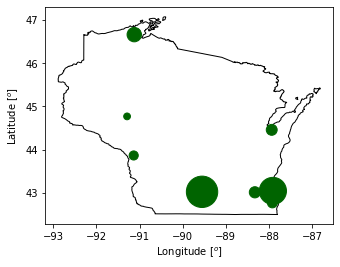

In [251]:
# fig, ax = plt.subplots(1, figsize=(7,8))
ax = country[country.NAME == state_long].plot(color='white', edgecolor='black')
ax.scatter(dfComb['LNG'],dfComb['LAT'], marker = '.', color = 'darkgreen', s= dfComb['POS OBS'])

ax.set_ylabel(r'Latitude [$^o$]')
ax.set_xlabel(r'Longitude [$^o$]')
plt.savefig('./map-prob1.png',dpi=80,bbox_inches='tight', pad_inches=0.02, format = 'png')
plt.show()

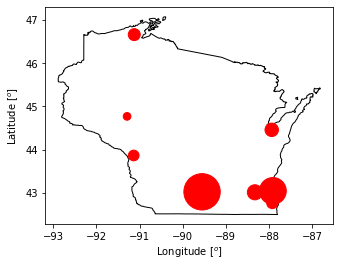

In [252]:
ax = country[country.NAME == state_long].plot(
    color='white', edgecolor='black')
ax.scatter(dfComb['LNG'],dfComb['LAT'], marker = '.', color = 'r', s= dfComb['TOT OBS']/1e2)

ax.set_ylabel(r'Latitude [$^o$]')
ax.set_xlabel(r'Longitude [$^o$]')

plt.savefig('./map-prob2.png',dpi=80,bbox_inches='tight', pad_inches=0.02, format = 'png')

plt.show()

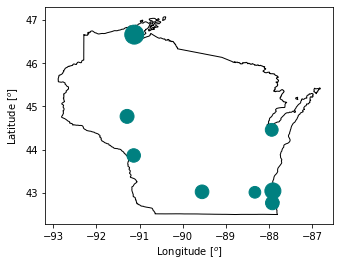

In [253]:
ax = country[country.NAME == state_long].plot(
    color='white', edgecolor='black')
ax.scatter(dfComb['LNG'],dfComb['LAT'], marker = '.', color = 'teal', s= dfComb['POS PROB']*1e5)

ax.set_ylabel(r'Latitude [$^o$]')
ax.set_xlabel(r'Longitude [$^o$]')

plt.savefig('./map-prob3.png',dpi=80,bbox_inches='tight', pad_inches=0.02, format = 'png')

plt.show()

In [177]:
countyList = list(countyName)
filter1 = dfAll['COUNTY'].isin(['Milwaukee', 'Dane','Waukesha', 'Brown', 'Racine', 'Bayfield', 'La Crosse', 'Eau Claire'])
# filter2 = dfAll['COMMON NAME'] == 'Yellow-rumped Warbler'
dfTime = dfAll[filter1].filter(['COMMON NAME','COUNTY','OBSERVATION DATE', 'ALL SPECIES REPORTED']) 
dfTime['OBSERVATION DATE'] = pd.to_datetime(dfTime['OBSERVATION DATE'])
dfTime['DAY'] = dfTime['OBSERVATION DATE'].dt.strftime('%j')

In [178]:
dfTime.head(5)

,COMMON NAME,COUNTY,OBSERVATION DATE,ALL SPECIES REPORTED,DAY
3,Red-eyed Vireo,Milwaukee,2018-06-07,1,158
4,Pine Siskin,Milwaukee,2018-08-08,1,220
6,Mallard,Waukesha,2018-04-24,1,114
7,Common Redpoll,Dane,2018-02-09,1,040
10,Mallard,Milwaukee,2018-05-18,1,138


In [189]:
aa = dfTime[dfTime['COUNTY']=='Eau Claire']

In [190]:
aa.groupby(['DAY']).sum().reset_index()

,DAY,ALL SPECIES REPORTED
0,001,113
1,002,32
2,003,38
3,004,23
4,005,31
...,...,...
358,361,65
359,362,42
360,363,45
361,364,13


In [198]:
dfPos = dfTime[dfTime['COMMON NAME']=='Yellow-rumped Warbler']

In [199]:
dfPos= dfPos.groupby(['DAY','COUNTY']).sum()#.reset_index()
dfPos.rename(columns = {'ALL SPECIES REPORTED':'POS OBS'}, inplace=True)

In [200]:
dfPos

POS OBS
DAY COUNTY           
001 Dane            1
005 Brown           1
006 Waukesha        1
013 Brown           2
    Waukesha        1
...               ...
350 Brown           3
352 Waukesha        1
356 Dane            1
358 Dane            1
360 Brown           1

[871 rows x 1 columns]

In [201]:
dfTot = dfTime.groupby(['DAY','COUNTY']).sum()#.reset_index()
dfTot.rename(columns = {'ALL SPECIES REPORTED':'TOT OBS'}, inplace=True)

In [202]:
dfTot

TOT OBS
DAY COUNTY             
001 Bayfield         95
    Brown           320
    Dane           2237
    Eau Claire      113
    La Crosse       119
...                 ...
365 Eau Claire       28
    La Crosse        60
    Milwaukee       193
    Racine           35
    Waukesha        128

[2916 rows x 1 columns]

In [204]:
dftest = dfPos.merge(dfTot, left_index=True, right_index = True, how = 'outer')

In [206]:
dftest["POS OBS"] = dftest["POS OBS"].fillna(0)

In [208]:
dftest['POS PROB'] = dftest['POS OBS']/dftest['TOT OBS']

In [211]:
dftest = dftest.reset_index()

In [214]:
dftest = dftest[filter1]

<ipython-input-214-140b7a09be2f>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  zz = dftest[filter1]


In [224]:
dftest['DAY'] = pd.to_numeric(dftest['DAY'])

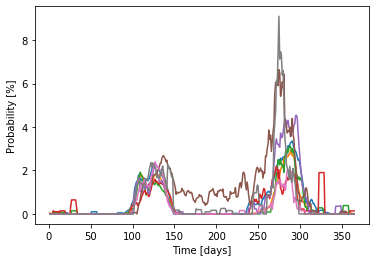

In [254]:
for place in ['Milwaukee', 'Dane','Waukesha', 'Brown', 'Racine', 'Bayfield', 'La Crosse', 'Eau Claire']:
    plt.plot(dftest[dftest['COUNTY'] == place]['DAY'],
             dftest[dftest['COUNTY'] == place]['POS PROB'].rolling(7, min_periods=1).mean()*100)
    
plt.xlabel('Time [days]')
plt.ylabel('Probability [%]')
plt.savefig('./plot-prob.png',dpi=80,bbox_inches='tight', pad_inches=0.02, format = 'png')
plt.show()

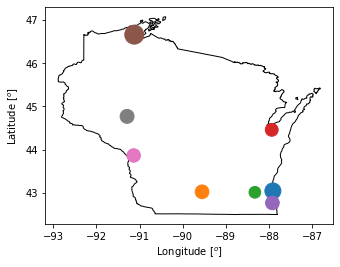

In [255]:
ax = country[country.NAME == state_long].plot(
    color='white', edgecolor='black')
ax.scatter(dfComb['LNG'],dfComb['LAT'], marker = '.', color = colorlist, s= dfComb['POS PROB']*1e5)

ax.set_ylabel(r'Latitude [$^o$]')
ax.set_xlabel(r'Longitude [$^o$]')

plt.savefig('./map-prob4.png',dpi=80,bbox_inches='tight', pad_inches=0.02, format = 'png')

plt.show()

In [240]:
colorlist = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink', 'tab:gray']

### Clustering using BDSCAN

BDSCAN is a density clustering that will tell where is popular for people to go birding (based on the desnity of hotsopts).  I will define a cluster as having atleast 3 point and with a maximum distance of 0.05degrees or about 5km.  With that I will optain where does each hotspot ('LOCALITY') belongs to. If '-1' they are not part of any cluster.

In [ ]:
DBScaner.cluster_selection?

In [ ]:
dfcluster, labels, n_clusters_ = DBScaner.cluster_selection(dfTrain, eps=0.02, min_samples=2)

In [ ]:
n_clusters_

In [ ]:
dfcluster.head(5)

In [ ]:
dfCounts = DBScaner.cluster_center(dfcluster, dfTrain)

In [ ]:
dfCounts.head(5)

### Now the bird probability.

`dfbdscan` have the information of where each of the hotspots lay, in terms of their cluster.  Now in order to constuct a path is important to mask the probabilites of the of seeing a particular bird with T or F on a weekly basis.  This is critical in order to construc the sets.

In [ ]:
dfProb = dfTrain.merge(dfcluster.filter(['locality','db_cluster']),
                            left_on='locality', right_on='locality', how = 'left').filter(['common_name','all_species_reported','year_week', 'db_cluster'])

In [ ]:
nTime = 54
nLoc = n_clusters_
setMat = np.empty((nTime,nLoc), dtype=object)

In [ ]:
dfProb[dfProb['common_name'] == 'Mallard']

In [ ]:
for week in range(0,nTime):
    dfProbA = dfProb[dfProb['year_week']== week]
    dfProb1 = dfProbA.groupby(['common_name','db_cluster']).sum().filter(['all_species_reported']).reset_index()
    dfProb1.rename(columns = {'all_species_reported':'pos_obs'}, inplace=True)
    dfProb2 = dfProbA.groupby(['db_cluster']).sum().filter(['all_species_reported']).reset_index()
    dfProb2.rename(columns = {'all_species_reported':'tot_obs'}, inplace=True)
    dfProb3 = dfProb1.merge(dfProb2, left_on='db_cluster', right_on='db_cluster', how = 'left')
    dfProb3['pos_prob'] = dfProb3['pos_obs']/dfProb3['tot_obs']
    for loc in range(0,nLoc):
        dfWeek = dfProb3[dfProb3['db_cluster'] == loc]
        dfWeek['tf'] = list(map(lambda x: 0 if x < 0.02 else 1, dfWeek['pos_prob']))
        setMat[week,loc] = set(dfWeek[dfWeek['tf'] == 1]['common_name'].values)
        

In [ ]:
ToMakeUniverse = list(setMat.flatten())
Universe = set(e for s in ToMakeUniverse for e in s)

In [ ]:
userInput = [lat,lng]

### Calculating google distances (dist matrix)

In [ ]:
gmaps = googlemaps.Client(key='{}'.format(Definition.GOOGLEKEY))

In [ ]:
coorHotspot = np.empty((n_clusters_+1, 2))
coorHotspot[:,0], coorHotspot[:,1] = dfCounts['longitude'],dfCounts['latitude']

In [ ]:
'''
Choose between this and the other seccion.  For test, use the other one, it does not use google dist function.
'''

# distMat = np.empty((nTime,n_clusters_))
# countBreak = divmod(n_clusters_,100)

# for i in range(0,countBreak[0]):
#     distanceMatGmaps = gmaps.distance_matrix(origins = (userInput[0],userInput[1]), 
#                                          destinations=list(coorHotspot[100*i:100*(i+1)]),
#                                          mode = 'driving', units = 'metric')
#     for j in range(100*i,100*(i+1)):
#         jj = j - 100*i
#         try:
#             distMat[:,j] = distanceMatGmaps['rows'][0]['elements'][jj]['duration']['value']/3600
#         except KeyError:
#             distMat[:,j] = 100
        
# distanceMatGmaps = gmaps.distance_matrix(origins = (userInput[0],userInput[1]), 
#                                          destinations=list(coorHotspot[countBreak[0]*100:]),
#                                          mode = 'driving', units = 'metric')

# for j in range(countBreak[0]*100,countBreak[0]*100+countBreak[1]):
#     jj = j - countBreak[0]*100
#     try:
#         distMat[:,j] = distanceMatGmaps['rows'][0]['elements'][jj]['duration']['value']/3600
#     except KeyError:
#         distMat[:,j] = 100

#==========================================================================
#==========================================================================
#==========================================================================

distMat = np.random.rand(nTime*n_clusters_).reshape((nTime,n_clusters_))

In [ ]:
setList, locList = SetCover.set_cover_weighted_greedy(Universe, ToMakeUniverse,list(distMat.flatten()))

In [ ]:
outLoc = Itinerary.location_list_maker(dfCounts,locList, nTime, n_clusters_)

In [ ]:
mapMarkerList = Itinerary.google_map_marker_list(dfCounts, outLoc)

In [ ]:
userOut2 = Itinerary.dic_user_ouput_maker(dfCounts,locList,nTime, nLoc)

In [ ]:
len(setList)

In [ ]:
len(locList)

In [ ]:
def google_map_marker_list(df, locations):
    '''
    Makes a python list that is use to generate the markers on the live google map.

    Arg:
        df: The dataframe form DBScaner.cluster_center.  It has the location name, lat, lgn and cluster number.
        locations:  The list of unique locations obtain from the set cover.
        
    Out:
        mapMakerList: python list with the form: [[location, latitude, longitue]....[..]]
    '''
    mapMarkerList = []
    for i in locations:
        lat = df.loc[df['locality'] == i].iloc[0]['latitude']
        lng = df.loc[df['locality'] == i].iloc[0]['longitude']
        mapMarkerList.append([i,lat,lng])
        
    return mapMarkerList


def location_list_maker(df, rawLocList, nTime, nLoc):
    '''
    Uses the raw output form the SetCover.set_cover_weighted_greedy or SetCover.set_cover_greedy methods to obtain the list of unique places that will be visited. The locations are transformed back to a (time,location) configuration and then just o a location format.
    
    Arg:
        rawLocList: Raw locations form the set_cover method.
        nTime: The number of time intervals (tipicaly 54)
        nLoc: The number of unique total hotspots.
        
    Out:
        outLoc: List of unique locations.
    
    '''
    locMat = np.linspace(1,nTime*nLoc,nTime*nLoc).reshape(nTime,nLoc)
    outLoc = set()
    for element in sorted(rawLocList):
        week,loc = np.where(locMat == element)
        outLoc |= set([df.loc[df['db_cluster'] == loc[0]].iloc[0]['locality']])
    outLoc = list(outLoc)
    return outLoc

def dic_user_ouput_maker(df, rawLocList, nTime, nLoc):
    '''
    Creates the dictionary that will be use to give the user the output it required.  The keys will be the different weeks and the entries the different location as labels.  The locations most likely will not make sence the the user and that is why the will have coordinates.
    
    Arg:
        rawLocList: Raw locations form the set_cover method.
        nTime: The number of time intervals (tipicaly 54)
        nLoc: The number of unique total hotspots.
        
    Out:
        userOut: dic with keys with the form of: 'week 1' and the values is a list of the different locations to visit.
    '''

    locMat = np.linspace(1,nTime*nLoc,nTime*nLoc).reshape(nTime,nLoc)

    userOut = {}
    for element in sorted(rawLocList):
        week,loc = np.where(locMat == element)
        placeNew = df.loc[df['db_cluster'] == loc[0]].iloc[0]['locality']
        key = 'week {}'.format(str(week[0]))
        if key in userOut.keys():
            placeOld = userOut[key]
            placeOld.extend([placeNew])
            userOut[key] = placeOld
        else:
            userOut[key] = [placeNew]
            
    return userOut

def table_creator(dfCounts, locList, setList, nTime, nLoc):
    locMat = np.linspace(1,nTime*nLoc,nTime*nLoc).reshape(nTime,nLoc)
    numLoc = len(locList)
    arrayWeeks = np.empty((numLoc), dtype = int)
    arrayLocName = np.empty((numLoc), dtype = object)
    arrayBirds = np.empty((numLoc), dtype = object)
    arrayLat = np.empty((numLoc))
    arrayLng = np.empty((numLoc))
    for i, element in enumerate(locList):
        week,loc = np.where(locMat == element)
        arrayWeeks[i] = int(week[0]+1)
        arrayLocName[i] = dfCounts.loc[dfCounts['db_cluster'] == loc[0]].iloc[0]['locality']
        arrayLat[i] = dfCounts.loc[dfCounts['db_cluster'] == loc[0]].iloc[0]['latitude']
        arrayLng[i] = dfCounts.loc[dfCounts['db_cluster'] == loc[0]].iloc[0]['longitude']
        arrayBirds[i] = ', '.join(list(setList[i]))
    dataTable = pd.DataFrame({'Week': arrayWeeks,
                      'Place': arrayLocName,
                      'Birds': arrayBirds,
                      'Lat': arrayLat,
                      'Lgn': arrayLng})
    dataTable.sort_values(by=['Week'], inplace=True)
    dataTable = dataTable.reset_index()
    dataTable.drop(['index'], axis=1, inplace=True)
        
    return dataTable

In [ ]:
for i, element in enumerate(locList):
    week,loc = np.where(locMat == element)
    arrayWeeks[i] = int(week[0]+1)
    arrayLocName[i] = dfCounts.loc[dfCounts['db_cluster'] == loc[0]].iloc[0]['locality']
    arrayLat[i] = dfCounts.loc[dfCounts['db_cluster'] == loc[0]].iloc[0]['latitude']
    arrayLng[i] = dfCounts.loc[dfCounts['db_cluster'] == loc[0]].iloc[0]['longitude']
    arrayBirds[i] = ', '.join(list(setList[i]))


In [ ]:
dataTable = pd.DataFrame({'Week': arrayWeeks,
                          'Place': arrayLocName,
                          'Birds': arrayBirds,
                          'Lat': arrayLat,
                          'Lgn': arrayLng})

In [ ]:
dataTable.sort_values(by=['Week'], inplace=True)

In [ ]:
dataTable = dataTable.reset_index()
dataTable.drop(['index'], axis=1, inplace=True)

In [ ]:
dataTable

In [ ]:
dataTable2 = table_creator(dfCounts, locList, setList, nTime, nLoc)

In [ ]:
dataTable2 == dataTable

In [ ]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(4)
money = [94604 , 166649, 97718, 253738]

def save_fig(name):
    fig.savefig(name,dpi=80,bbox_inches='tight', pad_inches=0.02, format = 'png')
    
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fk' % (x * 1e-3)


formatter = FuncFormatter(millions)

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(formatter)
plt.bar(x, money)
plt.ylabel('Num. Observation')
plt.xticks(x, ('Wisconsin', 'Texas', 'Colorado', 'California'))

save_fig('./state_obs.png')
plt.show()